In [1]:
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
data = np.array(pd.read_csv(r"C:\Users\Acer\Downloads\archive\mitbih_train.csv"))
data = data[67000:,:]
split_index = int(len(data) * 0.95)

mitbith_label = data[:,-1]
mitbith_train = data[:,:-1]


X_train = mitbith_train[:split_index]
X_test = mitbith_train[split_index:]

y_train = mitbith_label[:split_index]
y_test = mitbith_label[split_index:]

In [3]:
print(X_train.shape)

(19525, 187)


([<matplotlib.patches.Wedge at 0x247a2d750c0>,
 [Text(0.7373921116556221, 0.8162431461691196, 'class 1'),
  Text(-0.46973823095012557, 0.9946587326233288, 'class 2 '),
  Text(-1.0950481282871052, -0.10425735818112618, 'class 3'),
  Text(-0.5207732034154189, -0.9689144805422422, 'class 4'),
  Text(0.6099821701290733, -0.9153806596846071, 'class 5')])

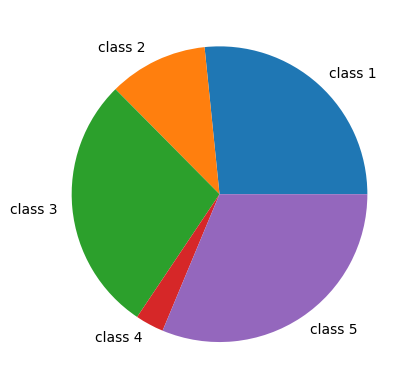

In [4]:
per_class1 = len(np.where(mitbith_label == 0.0)[0])/mitbith_label.shape[0]*100
per_class2 = len(np.where(mitbith_label == 1.0)[0])/mitbith_label.shape[0]*100
per_class3 = len(np.where(mitbith_label == 2.0)[0])/mitbith_label.shape[0]*100
per_class4 = len(np.where(mitbith_label == 3.0)[0])/mitbith_label.shape[0]*100
per_class5 = len(np.where(mitbith_label == 4.0)[0])/mitbith_label.shape[0]*100
per = [per_class1, per_class2, per_class3, per_class4, per_class5]
plt.pie(per,labels = ["class 1", "class 2 ", "class 3", "class 4","class 5"])

In [5]:
np.where(mitbith_label == 0.0)

(array([   0,    1,    2, ..., 5467, 5468, 5469], dtype=int64),)

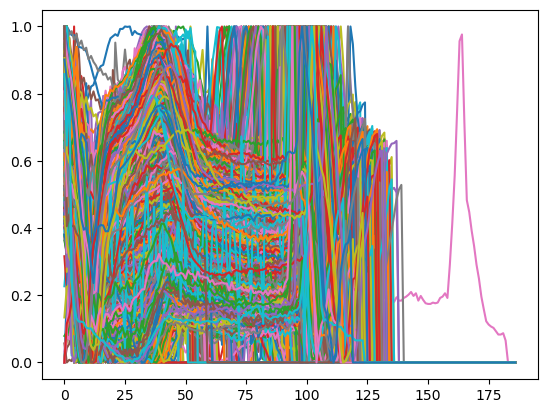

In [6]:
for i in range(len(mitbith_train)):
    if mitbith_label[i] == 4:
        plt.plot(mitbith_train[i])

In [7]:
class Dataset_ECG(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return torch.Tensor(self.X[i]).unsqueeze(0), torch.LongTensor([self.y[i]])

train_dataset = Dataset_ECG(X_train, y_train)
valid_dataset = Dataset_ECG(X_test, y_test)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

In [8]:
import torch.nn as nn 
class resblock(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = nn.Conv1d(32, 32, 5, padding = 'same')
        self.Conv2 = nn.Conv1d(32, 32, 5, padding = 'same')
        self.Pool = nn.MaxPool1d(5, stride = 2)
        self.f = nn.ReLU()
    def forward(self, data):
        output = self.Conv2(self.f(self.Conv1(data)))
        output = output + data
        output = self.Pool(self.f(output))
        return output
    
class ECGmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = nn.Conv1d(1, 32, 5, padding = 'same')
        self.Fc1 = nn.Linear(64, 32)
        self.Fc2 = nn.Linear(32, 5)
        self.res = []
        for i in range(5):
            self.res.append(resblock())
        self.f = nn.ReLU()
        self.Softmax = nn.Softmax()
        self.Flatten = nn.Flatten()
    def forward(self, data):
        output = self.Conv1(data)
        for resb in self.res:
            output = resb(output)
        output = self.Softmax(self.Fc2(self.f(self.Fc1(self.Flatten(output)))))
        return output

In [9]:
model = ECGmodel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
n_epochs = 50
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    total_loss = 0.0
    model.train()
    for index, data in (enumerate(train_loader)):
        x, y = data[0], data[1]
        y_pred = model(x)
        y = y.squeeze()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    correct = 0
    with torch.no_grad():
        y_train_pred = model(torch.Tensor(X_train).unsqueeze(1))
        for i in range(len(y_train_pred)):
            if np.argmax(y_train_pred[i]) == int(y_train[i]):
                correct += 1
    test_accuracy = correct / len(y_train)
    print('Train loss: {0}, Acc: {1}'.format(total_loss/len(train_loader), test_accuracy))
    train_loss.append(total_loss/len(train_loader))
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(valid_loader):
        x_batch, y_batch = batch[0], batch[1]

        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch.squeeze())
            running_loss += loss.item()
    avg_loss_across_batches = running_loss / len(valid_loader)
    correct = 0
    with torch.no_grad():
        y_valid_pred = model(torch.Tensor(X_test).unsqueeze(1))
        for i in range(len(y_valid_pred)):
            if np.argmax(y_valid_pred[i]) == int(y_test[i]):
                correct += 1
    accuracy = correct / len(y_test)
    val_loss.append(avg_loss_across_batches)
    print('Val Loss: {0:.3f}, Acc: {1}'.format(avg_loss_across_batches, accuracy))

C:\Users\Acer\anaconda3\envs\Deeplearning\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train loss: 1.3180771720497262, Acc: 0.7365428937259924
Val Loss: 1.053, Acc: 0.8803501945525292
Train loss: 1.1672647743318825, Acc: 0.7657362355953905
Val Loss: 1.031, Acc: 0.8852140077821011
Train loss: 1.1426968524731347, Acc: 0.7752112676056339
Val Loss: 1.021, Acc: 0.8881322957198443
Train loss: 1.1316031478742026, Acc: 0.7821766965428937
Val Loss: 1.013, Acc: 0.8939688715953308
Train loss: 1.1240819211771604, Acc: 0.7861715749039693
Val Loss: 1.014, Acc: 0.8929961089494164
Train loss: 1.1185646216758054, Acc: 0.7889372599231754
Val Loss: 1.019, Acc: 0.8891050583657587
Train loss: 1.11238180365746, Acc: 0.806606914212548
Val Loss: 1.015, Acc: 0.892023346303502
Train loss: 1.0862022238515812, Acc: 0.8352880921895006
Val Loss: 0.996, Acc: 0.9114785992217899
Train loss: 1.0664975212110446, Acc: 0.8539820742637644
Val Loss: 1.015, Acc: 0.8891050583657587
Train loss: 1.058709703391932, Acc: 0.858437900128041
Val Loss: 0.995, Acc: 0.9085603112840467
Train loss: 1.0533391526251128, Acc:

In [11]:
test_data = np.array(pd.read_csv(r"C:\Users\Acer\Downloads\archive\mitbih_test.csv"))
test_data = test_data[16500:,:]
X_test_data = test_data[:,:-1]
y_test_data = test_data[:, -1]
correct = 0
with torch.no_grad():
    y_valid_pred = model(torch.Tensor(X_test_data).unsqueeze(1))
    for i in range(len(y_valid_pred)):
        if np.argmax(y_valid_pred[i]) == int(y_test_data[i]):
            correct += 1
print(correct / len(y_test_data))

C:\Users\Acer\anaconda3\envs\Deeplearning\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.8812836208495641


In [19]:
y_test_pred = []
for i in range(len(y_valid_pred)):
    y_test_pred.append(np.argmax(y_valid_pred[i]))
    y_test_data[i] = int(y_test_data[i])

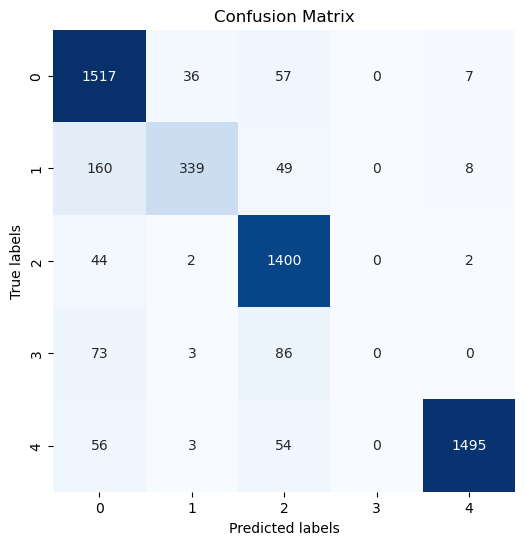

In [20]:
import seaborn as sns
cm = confusion_matrix(y_test_data, y_test_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

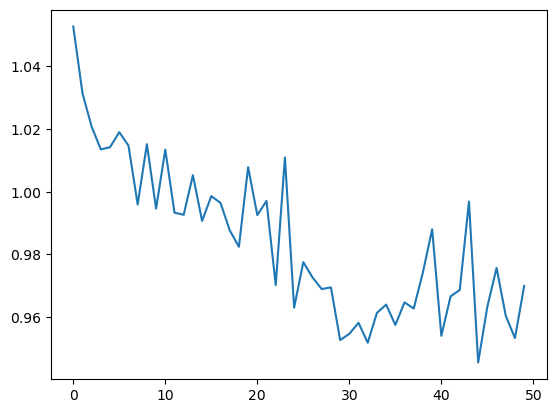

In [12]:
plt.plot(val_loss)